# sub044

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 

In [2]:
g1_4 = 'g1-4_v048'
g5 = 'g5_v041'

In [3]:
gs = [g1_4, g5]

In [4]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [5]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [6]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [7]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [8]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)
    
def vis(df, phone):
    gt = get_ground_truth()
    gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
    tmp1 = df[df['phone']==phone].copy()
    tmp2 = gt[gt['phone']==phone].copy()
    
    tmp1['phoneName'] = 'train'
    tmp2['phoneName'] = 'gt'
    
    tmp = pd.concat([tmp1, tmp2])
    tmp['collectionName'] = 'all'
    
    lat_center = tmp['latDeg'].mean()
    lng_center = tmp['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
        
    visualize_trafic(tmp, center)

In [9]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [10]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [11]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [12]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [13]:
sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
train = pd.DataFrame()
test = pd.DataFrame()

for g in gs:
    train = train.append(pd.read_csv(f'../output/{g}/{g}_train.csv'))
    test = test.append(pd.read_csv(f'../output/{g}/{g}_test.csv'))
    
print(len(train))
print(len(test))

131342
91486


In [14]:
result = train_result(train)
print(result.score)
display(result.err)

2.331179728118551


percentile50  percentile95  p50_p90_mean
phone                                                                        
2020-05-14-US-MTV-1_Pixel4               1.071486      1.729870      1.400678
2020-05-14-US-MTV-1_Pixel4XLModded       0.988828      1.585529      1.287179
2020-05-14-US-MTV-2_Pixel4               1.742174      2.541237      2.141705
2020-05-14-US-MTV-2_Pixel4XLModded       1.703691      2.858140      2.280915
2020-05-21-US-MTV-1_Pixel4               1.924152      3.374060      2.649106
2020-05-21-US-MTV-2_Pixel4               0.635920      1.714418      1.175169
2020-05-21-US-MTV-2_Pixel4XL             0.576553      1.687720      1.132137
2020-05-29-US-MTV-1_Pixel4               1.778136      2.629677      2.203906
2020-05-29-US-MTV-1_Pixel4XL             1.774641      2.621970      2.198305
2020-05-29-US-MTV-1_Pixel4XLModded       1.770548      2.630844      2.200696
2020-05-29-US-MTV-2_Pixel4               2.348241      3.531206      2.939723
2020-05-29-US-MTV-2_Pixel4XL             2.274847      3.554866      2.914856
2020-06-04-US-MTV-1_Pixel4               0.844403      1.881633      1.363018
2020-06-04-US-MTV-1_Pixel4XL             0.910024      1.905917      1.407971
2020-06-04-US-MTV-1_Pixel4XLModded       0.924244      2.216337      1.570291
2020-06-05-US-MTV-1_Pixel4               0.763374      1.997096      1.380235
2020-06-05-US-MTV-1_Pixel4XL             0.800689      2.492664      1.646677
2020-06-05-US-MTV-1_Pixel4XLModded       0.737693      2.839179      1.788436
2020-06-05-US-MTV-2_Pixel4               1.059249      2.302663      1.680956
2020-06-05-US-MTV-2_Pixel4XL             1.032693      2.215739      1.624216
2020-06-11-US-MTV-1_Pixel4               0.703906      1.661540      1.182723
2020-06-11-US-MTV-1_Pixel4XL             0.712203      1.745695      1.228949
2020-07-08-US-MTV-1_Pixel4               0.785447      1.809260      1.297354
2020-07-08-US-MTV-1_Pixel4XL             0.744760      1.662087      1.203424
2020-07-08-US-MTV-1_Pixel4XLModded       0.621426      1.485962      1.053694
2020-07-17-US-MTV-1_Mi8                  1.824626      3.478586      2.651606
2020-07-17-US-MTV-2_Mi8                  2.832676      4.188406      3.510541
2020-08-03-US-MTV-1_Mi8                  1.504968      2.360111      1.932540
2020-08-03-US-MTV-1_Pixel4               1.643539      2.452855      2.048197
2020-08-06-US-MTV-2_Mi8                  0.749353      1.785398      1.267376
2020-08-06-US-MTV-2_Pixel4               0.740076      1.774372      1.257224
2020-08-06-US-MTV-2_Pixel4XL             0.734161      1.802156      1.268159
2020-09-04-US-SF-1_Mi8                   1.018366      2.562062      1.790214
2020-09-04-US-SF-1_Pixel4                1.090758      3.000479      2.045618
2020-09-04-US-SF-1_Pixel4XL              1.036071      2.751033      1.893552
2020-09-04-US-SF-2_Mi8                   1.029356      4.450926      2.740141
2020-09-04-US-SF-2_Pixel4                0.775437      3.126145      1.950791
2020-09-04-US-SF-2_Pixel4XL              0.756889      3.100788      1.928839
2021-01-04-US-RWC-1_Pixel4               0.772700      2.023550      1.398125
2021-01-04-US-RWC-1_Pixel4Modded         0.915718      2.232248      1.573983
2021-01-04-US-RWC-1_Pixel4XL             0.787201      2.072520      1.429861
2021-01-04-US-RWC-1_Pixel5               0.782432      2.066413      1.424422
2021-01-04-US-RWC-2_Pixel4               1.003874      2.463034      1.733454
2021-01-04-US-RWC-2_Pixel4Modded         1.105437      2.651179      1.878308
2021-01-04-US-RWC-2_Pixel4XL             1.018949      2.479600      1.749274
2021-01-04-US-RWC-2_Pixel5               1.011890      3.180728      2.096309
2021-01-05-US-SVL-1_Mi8                  1.272820      3.398299      2.335560
2021-01-05-US-SVL-1_Pixel4               1.457378      3.598041      2.527710
2021-01-05-US-SVL-1_Pixel4XL             1.391993      3.537933      2.464963
2021-01-05-US-SVL-1_Pixel5               1.375031      3.45

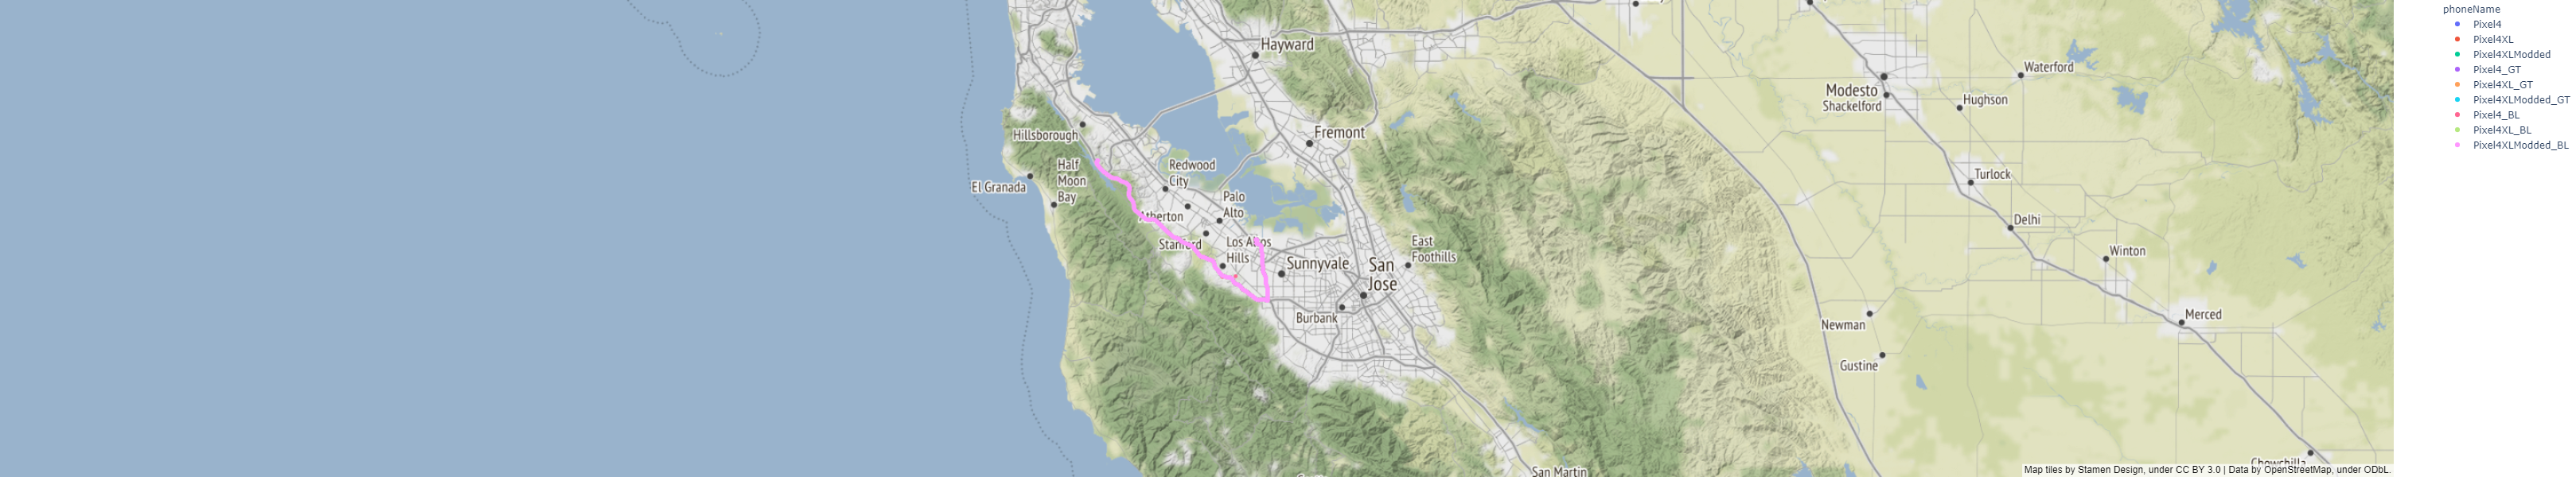

In [15]:
result.viz_map('2020-05-29-US-MTV-1')

In [16]:
del sub['latDeg']
del sub['lngDeg']

In [17]:
sub = sub.merge(test[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['phone', 'millisSinceGpsEpoch'], how='left')

In [18]:
train.to_csv(f'{OUTPUT}/{nb_name}_train.csv', index=False)
sub.to_csv(f'{OUTPUT}/{nb_name}_sub.csv', index=False)

# 誤差マップ

In [19]:
gt = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})

In [20]:
gt

collectionName        phoneName  millisSinceGpsEpoch  latDeg_gt  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442  37.423576   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442  37.423576   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442  37.423576   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442  37.423576   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442  37.423576   
...                     ...              ...                  ...        ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000  37.334475   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000  37.334475   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000  37.334475   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000  37.334475   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000  37.334475   

         lngDeg_gt  heightAboveWgs84EllipsoidM  timeSinceFirstFixSeconds  \
0      -122.094132                       33.21                    551.44   
1      -122.094132                       33.21                    552.44   
2      -122.094132                       33.21                    553.44   
3      -122.094132                       33.20                    554.44   
4      -122.094132                       33.20                    555.44   
...            ...                         ...                       ...   
131337 -121.899613                       56.62                   2632.00   
131338 -121.899613                       56.62                   2633.00   
131339 -121.899613                       56.62                   2634.00   
131340 -121.899613                       56.63                   2635.00   
131341 -121.899613                       56.64                   2636.00   

        hDop  vDop  speedMps  courseDegree  
0        1.1   0.0       0.0          12.7  
1        1.1   0.0       0.0          12.7  
2        1.1   0.0       0.0          12.7  
3        1.1   0.0       0.0          12.7  
4        1.1   0.0       0.0          12.7  
...      ...   ...       ...           ...  
131337   1.1   0.0       0.0          60.0  
131338   1.1   0.0       0.0          60.0  
131339   0.9   0.0       0.0          60.0  
131340   1.0   0.0       0.0          60.0  
131341   1.1   0.0       0.0          60.0  

[131342 rows x 11 columns]

In [21]:
train = train.merge(gt[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt', 'speedMps', 'courseDegree']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')

In [22]:
train['err'] = calc_haversine(train['latDeg'], train['lngDeg'], train['latDeg_gt'], train['lngDeg_gt'])

In [23]:
phones = train['phone'].unique()

In [24]:
os.makedirs(f'{OUTPUT}/train/map', exist_ok=True)

In [25]:
for phone in phones:
    tmp = train[train['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(30, 30))
    sns.scatterplot(x='latDeg', y='lngDeg', hue='err', data=tmp, size='err', s=100, alpha=0.8, lw=0, ax=axes)
    axes.invert_xaxis()
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/map/{phone}.png')
    plt.close()

In [26]:
os.makedirs(f'{OUTPUT}/test/map', exist_ok=True)

In [27]:
for phone in test['phone'].unique():
    tmp = test[test['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(30, 30))
    sns.scatterplot(x='latDeg', y='lngDeg', data=tmp, alpha=0.8, lw=0, ax=axes)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/test/map/{phone}.png')
    plt.close()

# 誤差推移

In [28]:
train['millis_diff'] = train['millisSinceGpsEpoch'] - train.groupby('phone')['millisSinceGpsEpoch'].shift(1)

In [29]:
os.makedirs(f'{OUTPUT}/train/transition', exist_ok=True)

In [30]:
for phone in train['phone'].unique():
    tmp = train[train['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(40, 20), nrows=4,sharex=True)
    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')
    axes[0].legend(loc='upper right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['courseDegree'], label='courseDegree')
    axes[1].legend(loc='upper right')
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[2].plot(tmp['millisSinceGpsEpoch'], tmp['millis_diff'], label='millis_diff')
    axes[2].legend(loc='upper right')
    axes[2].grid(color='g', linestyle=':', linewidth=0.3)
    
    axes[3].plot(tmp['millisSinceGpsEpoch'], tmp['err'], label='err')
    axes[3].legend(loc='upper right')
    axes[3].grid(color='g', linestyle=':', linewidth=0.3)
    
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/train/transition/{phone}.png')
    plt.close()

In [31]:
os.makedirs(f'{OUTPUT}/test/transition', exist_ok=True)

In [32]:
test['millis_diff'] = test['millisSinceGpsEpoch'] - test.groupby('phone')['millisSinceGpsEpoch'].shift(1)

In [33]:
for phone in test['phone'].unique():
    tmp = test[test['phone']==phone].copy()
    fig, axes = plt.subplots(figsize=(40, 10), nrows=1,sharex=True)
    axes.plot(tmp['millisSinceGpsEpoch'], tmp['millis_diff'], label='millis_diff')
    axes.legend(loc='upper right')
    axes.grid(color='g', linestyle=':', linewidth=0.3)
    
    fig.suptitle(phone, fontsize=16)
    fig.savefig(f'{OUTPUT}/test/transition/{phone}.png')
    plt.close()

In [34]:
result.viz_map('2020-05-29-US-MTV-1')